## Rank ChEMBL antivirals and all drugs using cosine similarity to SARS-CoV-2

In this notebook, we rank ChEMBL antiviral drugs and other sets of drugs for their suitability for COVID-19 repurposing using their cosine similarity to SARS-CoV-2 in latent space, using our KG embeddings.

### Set variables

In [1]:
import os

base_dl_dir = "downloaded_data"
graph_data_dir = os.path.join(base_dl_dir, "kg-covid-19-20201012")
embedding_data_dir = os.path.join(base_dl_dir, "embeddings-20201012")

# graph stuff
graph_out_file = os.path.join(graph_data_dir + "/kg-covid-19.tar.gz")
nodes_file = os.path.join(graph_data_dir, "merged-kg_nodes.tsv")
edges_file = os.path.join(graph_data_dir, "merged-kg_edges.tsv")
sorted_edges_file = os.path.join(graph_data_dir, "merged-kg_edges_SORTED.tsv")
graph_tar_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201012/kg-covid-19.tar.gz"

# embeddings URLs
base_kghub_url = "http://kg-hub.berkeleybop.io/"
embeddings_url = os.path.join(base_kghub_url, "embeddings/20201012/SkipGram_80_20_kg_covid_19_20201012_training_test_epoch_500_delta_0.0001_embedding.npy")
embedding_file = os.path.join(embedding_data_dir, "SkipGram_embedding.npy")

# params
seed = 42
train_percentage = 0.8
patience = 5

In [2]:
chembl_antiviral_cosine_sim_outfile = "chembl_antiviral_cosine_sim.tsv"

chembl_antiviral_dir = os.path.join(base_dl_dir, "chembl_antiviral-20201012")

chembl_prefix = 'CHEMBL.COMPOUND'
chembl_nodes_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201012/transformed/ChEMBL/nodes.tsv"
chembl_nodes_file = os.path.join(chembl_antiviral_dir, "nodes.tsv")
chembl_antiviral_file = os.path.join(chembl_antiviral_dir, "sars_cov_2_compounds.txt")

In [3]:
sars_cov_2_gpi_dir = os.path.join(base_dl_dir, "sars-cov-2-gpi")
sars_cov_2_gpi_file = os.path.join(sars_cov_2_gpi_dir, "uniprot_sars-cov-2.gpi")
sars_cov_2_gpi_url = "https://raw.githubusercontent.com/Knowledge-Graph-Hub/kg-covid-19/master/curated/ORFs/uniprot_sars-cov-2.gpi"

In [4]:
sars_cov_2_curie = 'NCBITaxon:2697049'

In [5]:
from pkg_resources import get_distribution
assert(get_distribution("ensmallen-graph").version == '0.4.4')
assert(get_distribution("embiggen").version == '0.6.0')

#### Download the graph if necessary

In [6]:
import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)

if not os.path.exists(nodes_file) or not os.path.exists(edges_file):
    with urllib.request.urlopen(graph_tar_url) as response, \
        open(graph_out_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)
    os.system("tar -xvzf " + graph_out_file + " -C " + graph_data_dir)

#### Download embeddings if necessary

In [7]:
os.makedirs(embedding_data_dir, exist_ok=True)

if not os.path.exists(embedding_file):
    with urllib.request.urlopen(embeddings_url) as response, \
        open(embedding_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

#### Make a sorted edge file if necessary

In [8]:
%%time
from ensmallen_graph import EnsmallenGraph

if not os.path.exists(sorted_edges_file):
    graph = EnsmallenGraph.from_unsorted_csv(
        edge_path = edges_file,
        sources_column="subject",
        destinations_column="object",
        directed=False,
        node_path = nodes_file,
        nodes_column = 'id',
        node_types_column = 'category',
        default_node_type = 'biolink:NamedThing'
    )

    graph.dump_edges(sorted_edges_file,
        sources_column="subject",
        destinations_column="object")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 907 µs


In [14]:
%%time
from ensmallen_graph import EnsmallenGraph

graph = EnsmallenGraph.from_sorted_csv(
    edge_path = sorted_edges_file,
    sources_column="subject",
    destinations_column="object",
    directed=False,
    nodes_number=500000,  # should be = or > than actual number
    edges_number=42949369,   # same ^
    node_path = nodes_file,
    nodes_column = 'id',
    node_types_column = 'category',
    default_node_type = 'biolink:NamedThing'
)

graph.report()

CPU times: user 36.7 s, sys: 492 ms, total: 37.2 s
Wall time: 36.9 s


{'self_loops_rate': '0.000015373068830289457',
 'self_loops_number': '480',
 'directed': 'false',
 'unique_edge_types_number': '0',
 'density': '0.010673045865565448',
 'singletons': '8355',
 'edges_number': '31223434',
 'unique_node_types_number': '42',
 'degree_mean': '69.73158748096104',
 'has_node_types': 'true',
 'undirected_edges_number': '15611957',
 'name': 'Graph',
 'has_weights': 'false',
 'nodes_number': '447766',
 'has_edge_types': 'false'}

In [15]:
%%time
pos_training, pos_validation = graph.connected_holdout(train_size=train_percentage, random_state=seed)

CPU times: user 3min 10s, sys: 640 ms, total: 3min 11s
Wall time: 3min 10s


The followings are not strictly necessary, but are offered as sanity checks:

In [16]:
%%time
coherence_check=True
if coherence_check:
    assert graph.contains(pos_training)
    assert graph.contains(pos_validation)
    assert (pos_training | pos_validation).contains(graph)
    assert graph.contains(pos_training | pos_validation)
    assert not pos_training.overlaps(pos_validation)
    assert not pos_validation.overlaps(pos_training)

CPU times: user 26min 47s, sys: 2.19 s, total: 26min 49s
Wall time: 4min 26s


## Load the embeddings

In [17]:
import numpy as np
embeddings = np.load(embedding_file)

## Load curies and names for nodes

In [18]:
node_curies = list(np.array(pos_training.get_nodes_reverse_mapping()))

In [19]:
node_names = []

node_curie_name_mapping = {}
with open(nodes_file, 'r') as n:
    header = n.readline().split("\t")
    lines = n.readlines()
    for line in lines:
        fields = line.split("\t")
        node_curie_name_mapping[fields[header.index("id")]] = fields[header.index("name")]

for i, this_curie in enumerate(node_curies):
    node_names.append(node_curie_name_mapping[this_curie] if this_curie in node_curie_name_mapping else '')

In [20]:
assert len(node_curies) == len(embeddings)

### Get graph nodes representating SARS-CoV-2 and all its proteins (nodes of interest)

In [21]:
sars_cov_2_idx = node_curies.index(sars_cov_2_curie)

In [24]:
nodes_of_interest = [
    {'name': 'SARS-CoV-2',
     'curie': sars_cov_2_curie,
     'node_id': node_curies.index(sars_cov_2_curie)
    }
]

In [25]:
import wget

if not os.path.exists(sars_cov_2_gpi_file):
    os.makedirs(sars_cov_2_gpi_dir, exist_ok=True)
    filename = wget.download(sars_cov_2_gpi_url, sars_cov_2_gpi_file)

with open(sars_cov_2_gpi_file, 'r') as gpi:
    lines = gpi.readlines()
    # print("NAME\tDB ID")
    for line in lines:
        if line.startswith("!"):
            continue
        fields = line.split("\t")
        this_curie = ":".join([fields[0], fields[1]])
        nodes_of_interest.append({'name': fields[2],
                                  'curie': this_curie,
                                  'node_id': node_curies.index(this_curie)
                                 })

### method to compute matrix of cosine similarities

In [26]:
from tqdm import tqdm
from scipy import spatial

def get_cosine_sim(x: list, y: list, embeddings: np.ndarray) ->  np.ndarray:
    cosine_sim = np.full((len(x), len(y)), -1000.0000)

    # precompute node idx to speed things up
    x_node_idx = [node_curies.index(i) for i in tqdm(x, "preloading x node indexes")]
    y_node_idx = [node_curies.index(i) for i in tqdm(y, "preloading y node indexes")]

    for i, row_curie in tqdm(enumerate(x), "computing cosine sim"):
        for j, col_curie in enumerate(y):
            row_emb = embeddings[x_node_idx[i]]
            col_emb = embeddings[y_node_idx[j]]
            cosine_sim[i,j] = 1 - spatial.distance.cosine(row_emb, col_emb)

    return cosine_sim

## Rank ChEMBL antivirals by cosine similarity to SARS-CoV-2

In [27]:
if not os.path.exists(os.path.join(chembl_nodes_file)):
    os.makedirs(chembl_antiviral_dir, exist_ok=True)
    with urllib.request.urlopen(chembl_nodes_url) as response, \
        open(chembl_nodes_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [28]:
import re

chembl_antiviral_curies = []
chembl_antiviral_names = []
chembl_antiviral_smile = []

with open(chembl_nodes_file, 'r') as f:
    header = f.readline().split("\t")
    lines = f.readlines()
    for line in lines:
        items = line.split("\t")
        this_id = items[header.index("id")]
        this_name = items[header.index("name")]
        this_smile = items[header.index("canonical_smiles")]
        if re.match(chembl_prefix, this_id):
            chembl_antiviral_curies.append(this_id)
            chembl_antiviral_names.append(this_name)
            chembl_antiviral_smile.append(this_smile)

In [29]:
chembl_antiviral_cosine_sim = get_cosine_sim(
    chembl_antiviral_curies,
    [i.get("curie") for i in nodes_of_interest],
    embeddings
    )

preloading y node indexes: 100%|██████████| 33/33 [00:00<00:00, 207.87it/s]
computing cosine sim: 6900it [00:09, 722.38it/s]


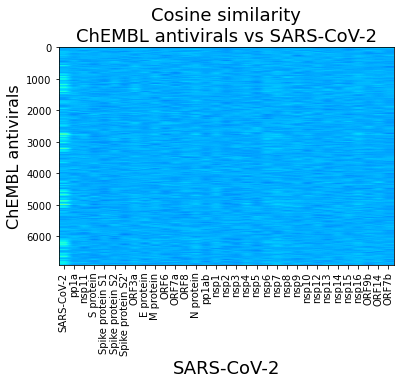

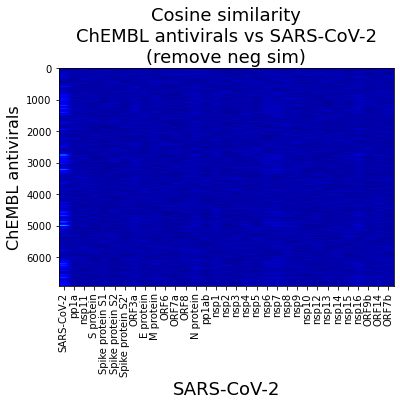

In [30]:
# why not
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(chembl_antiviral_cosine_sim, cmap='jet', aspect='auto')
plt.title("Cosine similarity\nChEMBL antivirals vs SARS-CoV-2", fontsize=18)
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('ChEMBL antivirals', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90
          )
plt.show()


z = chembl_antiviral_cosine_sim.copy()
z[z < 0] = 0

plt.imshow(z, cmap='jet', aspect='auto')
plt.title("Cosine similarity\nChEMBL antivirals vs SARS-CoV-2\n(remove neg sim)", fontsize=18)
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('ChEMBL antivirals', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90)
plt.show()

In [32]:
noi_col_curies = [i.get("curie") for i in nodes_of_interest]

chembl_antivirals_ranked = [[z,y,x] for x,y,z in sorted(
    zip(
        chembl_antiviral_cosine_sim[:,noi_col_curies.index(sars_cov_2_curie)],
        chembl_antiviral_curies,
        chembl_antiviral_names
        ),
    key=lambda pair: pair[0], reverse=True)]

In [33]:
chembl_antivirals_ranked

[['CYCLOPHOSPHAMIDE', 'CHEMBL.COMPOUND:CHEMBL88', 0.9997466206550598],
 ['PENICILLIN V', 'CHEMBL.COMPOUND:CHEMBL615', 0.9997187256813049],
 ['AZITHROMYCIN', 'CHEMBL.COMPOUND:CHEMBL529', 0.9996907114982605],
 ['ACETYLCYSTEINE', 'CHEMBL.COMPOUND:CHEMBL600', 0.999679684638977],
 ['UMIFENOVIR', 'CHEMBL.COMPOUND:CHEMBL1214598', 0.9996674656867981],
 ['BENZYLPENICILLIN', 'CHEMBL.COMPOUND:CHEMBL29', 0.999661922454834],
 ['FAMCICLOVIR', 'CHEMBL.COMPOUND:CHEMBL880', 0.9996476173400879],
 ['', 'CHEMBL.COMPOUND:CHEMBL1319514', 0.999630331993103],
 ['ASCORBIC ACID', 'CHEMBL.COMPOUND:CHEMBL196', 0.9996060729026794],
 ['', 'CHEMBL.COMPOUND:CHEMBL3273984', 0.9996046423912048],
 ['CEFTRIAXONE', 'CHEMBL.COMPOUND:CHEMBL161', 0.9995980262756348],
 ['AMOXICILLIN', 'CHEMBL.COMPOUND:CHEMBL1082', 0.9995885491371155],
 ['GUANIDINE', 'CHEMBL.COMPOUND:CHEMBL821', 0.9995810985565186],
 ['', 'CHEMBL.COMPOUND:CHEMBL261491', 0.9995764493942261],
 ['METHYLPREDNISOLONE', 'CHEMBL.COMPOUND:CHEMBL650', 0.999564290046691

In [34]:
import csv

with open(chembl_antiviral_cosine_sim_outfile, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(chembl_antivirals_ranked)

## Rank all drugs by cosine sim to SARS-CoV-2

In [35]:
assert len(pos_training.get_node_types()) == len(embeddings)

In [36]:
drug_idx = list(np.where(pos_training.get_node_types() == pos_training.get_node_types_reverse_mapping().index('biolink:Drug'))[0])
drug_curies = [node_curies[i] for i in drug_idx]
drug_cosine_sim = get_cosine_sim(
    drug_curies,
    [i.get("curie") for i in nodes_of_interest],
    embeddings
    )

preloading y node indexes: 100%|██████████| 33/33 [00:00<00:00, 200.75it/s]
computing cosine sim: 32120it [00:45, 706.75it/s]


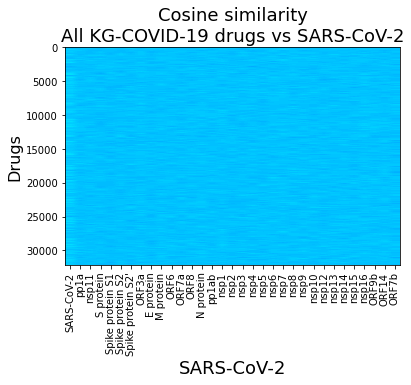

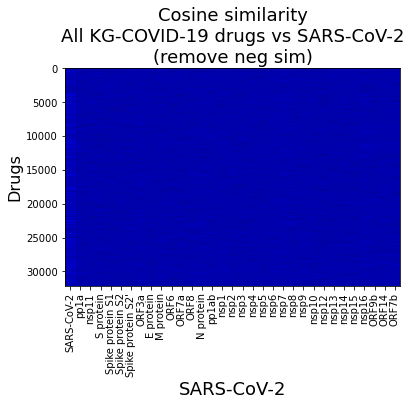

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(drug_cosine_sim, cmap='jet', aspect='auto')
plt.title("Cosine similarity\nAll KG-COVID-19 drugs vs SARS-CoV-2", fontsize=18)
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('Drugs', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90
          )
plt.show()


z = drug_cosine_sim.copy()
z[z < 0] = 0

plt.imshow(z, cmap='jet', aspect='auto')
plt.title("Cosine similarity\nAll KG-COVID-19 drugs vs SARS-CoV-2\n(remove neg sim)", fontsize=18)
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('Drugs', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90)
plt.show()

In [41]:
drugs_ranked = [[z,y,x] for x,y,z in sorted(
    zip(
        drug_cosine_sim[:,noi_col_curies.index(sars_cov_2_curie)],
        node_curies,
        node_names
        ),
      key=lambda pair: pair[0], reverse=True)]

In [42]:
drugs_ranked[0:10]

[['POC1A', 'ENSEMBL:ENSG00000164087', 0.9987318515777588],
 ['TEX38', 'ENSEMBL:ENSG00000186118', 0.9987178444862366],
 ['PRAMEF12', 'ENSEMBL:ENSG00000116726', 0.9986842274665833],
 ['SPDYA', 'ENSEMBL:ENSG00000163806', 0.9986816644668579],
 ['GGH', 'ENSEMBL:ENSG00000137563', 0.9986295104026794],
 ['ARMH3', 'ENSEMBL:ENSG00000120029', 0.9985998272895813],
 ['', 'UniProtKB:Q96M63', 0.9985941648483276],
 ['', 'UniProtKB:Q07654', 0.9985929727554321],
 ['', 'UniProtKB:Q8WV37', 0.9985926151275635],
 ['AKR1C3', 'UniProtKB:P42330', 0.9985882639884949]]

## Sort everything by closeness to SARS-CoV-2

In [43]:
everything_cosine_sim = get_cosine_sim(
    node_curies,
    [i.get("curie") for i in nodes_of_interest],
    embeddings
    )

preloading y node indexes: 100%|██████████| 33/33 [00:00<00:00, 194.23it/s]
computing cosine sim: 447766it [11:05, 673.32it/s]


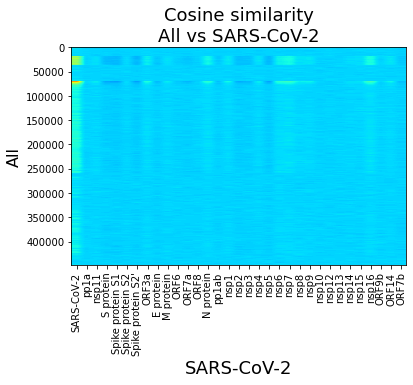

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(everything_cosine_sim, cmap='jet', aspect='auto')
plt.title("Cosine similarity\nAll vs SARS-CoV-2", fontsize=18)
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('All', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90
          )
plt.show()


In [46]:
everything_ranked = [[z,y,x] for x,y,z in sorted(
    zip(
         everything_cosine_sim[:,noi_col_curies.index(sars_cov_2_curie)],
        node_curies,
        node_names
        ),
      key=lambda pair: pair[0], reverse=True)]


In [47]:
everything_ranked[0:100]

[['Severe acute respiratory syndrome coronavirus 2', 'NCBITaxon:2697049', 1.0],
 ['United States of America', 'WD:Q30', 0.9998204112052917],
 ['Pneumonia', 'HP:0002090', 0.9997919201850891],
 ['growth', 'GO:0040007', 0.9997748136520386],
 ['obsolete transmission of virus', 'GO:0019089', 0.9997747540473938],
 ['', 'MESH:D017934', 0.9997715950012207],
 ['', 'MESH:D018352', 0.9997633695602417],
 ['', 'MESH:D007251', 0.9997578859329224],
 ['CYCLOPHOSPHAMIDE', 'CHEMBL.COMPOUND:CHEMBL88', 0.9997466206550598],
 ['', 'MESH:SDI0026', 0.9997462630271912],
 ['SARS', 'NCBITaxon:227859', 0.9997444152832031],
 ['Compensating for the ‘Authoritarian Advantage’ in Crisis Response: A Comparative Case Study of SARS Pandemic Responses in China and Taiwan',
  'CORD:PMC7111788',
  0.9997312426567078],
 ['', 'MESH:D012128', 0.9997300505638123],
 ['ANesthesiA & ANALGesiA Letters to the Editor',
  'CORD:6445e1d32b4fb40b3fdb8d6843338ec84eb5e8f6',
  0.9997267723083496],
 ['', 'MESH:D006408', 0.9997263550758362],